In [1]:
import pandas as pd
import FWI
import matplotlib.pyplot as plt
import numpy as np

def total_precipitation(initial_date, final_date, dmet):
    dmet['hourly.time'] = pd.to_datetime(dmet['hourly.time'])
    dmet_copy = dmet.copy()
    dmet_copy.set_index('hourly.time', inplace=True)
    selected_rows = dmet_copy.loc[initial_date:final_date]
    total_precipitation = selected_rows['hourly.precipitation'].sum()

    return total_precipitation

In [7]:
dmet = pd.read_csv('Samples/2022/2022.csv')
dmet_filtered = dmet[dmet['hourly.time'].str.contains('T12:00')]
dmet_filtered.to_csv('Samples/2022/2022MidDay.csv', index=False)

In [10]:
dmet_filtered = pd.read_csv('Samples/2022/2022MidDay.csv')
dmet = pd.read_csv('Samples/2022/2022.csv')
start_index = 0 + 1 # O FWI é calculado a partir das 12h


'''
FWI:21.95067024230957
Drought Code (DC):  418.90625
Duff Moisture Code (DMC):  160.0711212158203
Fine Fuel Moisture Code (FFMC):  86.57350158691406
 

'''
LAT = 40.0299179999034
FFMCPrev = 86.57350158691406
DMCPrev = 160.0711212158203
DCPrev = 418.90625

mts = {5: 31,
       6: 30,
       7: 31,
       8:31, 
       9:30, 
       10:31}


fwix_values = [None] * len(dmet_filtered)
ffmc_values = [None] * len(dmet_filtered)
dmc_values = [None] * len(dmet_filtered)
dc_values = [None] * len(dmet_filtered)
isi_values = [None] * len(dmet_filtered)
bui_values = [None] * len(dmet_filtered)


for i in range(start_index, len(dmet_filtered)):
    MONTH = (dmet_filtered.iloc[i]['hourly.time']).split('-')[1]
    DAY = (dmet_filtered.iloc[i]['hourly.time']).split('-')[2].split('T')[0]

    print(MONTH, DAY)

    TEMP = dmet_filtered.iloc[i]['hourly.temperature_2m']
    RH = dmet_filtered.iloc[i]['hourly.relative_humidity_2m']
    WIND = dmet_filtered.iloc[i]['hourly.wind_speed_10m']


    if(int(DAY) == 1):
        LAST_DAY = mts[int(MONTH) - 1]
        LAST_MONTH = str(int(MONTH) - 1)
        
        if(int(LAST_MONTH) < 10):
            LAST_MONTH = '0' + str(int(LAST_MONTH))
            
        initial_date = f'2022-{LAST_MONTH}-{LAST_DAY}T12:00'
        final_date = f'2022-{MONTH}-{DAY}T12:00'

    elif((int(DAY) < 10) and (int(DAY) > 1)):
        id = '0' + str(int(DAY)-1)
        fd = '0' + str(int(DAY))

        initial_date = f'2022-{MONTH}-{id}T12:00'
        final_date = f'2022-{MONTH}-{fd}T12:00'
    else:
        id = str(int(DAY)-1)
        fd = str(int(DAY))

        initial_date = f'2022-{MONTH}-{id}T12:00'
        final_date = f'2022-{MONTH}-{fd}T12:00'

    
    RAIN = total_precipitation(initial_date, final_date, dmet)
    
    FFMCPrev = FWI.FFMC(TEMP,RH,WIND,RAIN,FFMCPrev)
    DMCPrev = FWI.DMC(TEMP,RH,RAIN,DMCPrev,LAT,int(MONTH))
    DCPrev = FWI.DC(TEMP,RAIN,DCPrev,LAT,int(MONTH))
    isi = FWI.ISI(WIND, FFMCPrev)
    bui = FWI.BUI(DMCPrev,DCPrev)
    fwix = FWI.FWI(isi, bui)

    fwix_values[i] = fwix
    ffmc_values[i] = FFMCPrev
    dmc_values[i] = DMCPrev
    dc_values[i] = DCPrev
    isi_values[i] = isi
    bui_values[i] = bui


dmet_filtered['fwix'] = fwix_values
dmet_filtered['ffmc'] = ffmc_values
dmet_filtered['dmc'] = dmc_values
dmet_filtered['dc'] = dc_values
dmet_filtered['isi'] = isi_values
dmet_filtered['bui'] = bui_values


dmet_filtered.to_csv('Samples/2022/2022MidDayFWIX.csv', index=False)

06 21
06 22
06 23
06 24
06 25
06 26
06 27
06 28
06 29
06 30
07 01
07 02
07 03
07 04
07 05


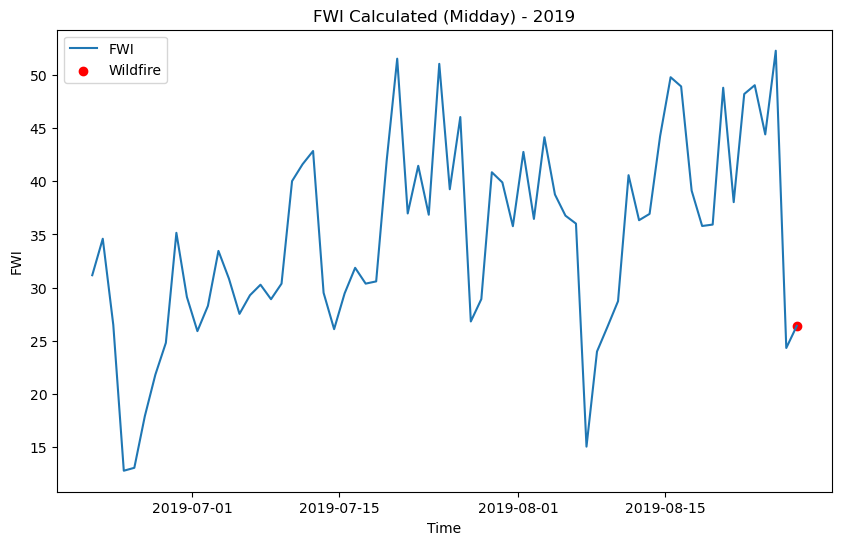

In [3]:
ofmd = pd.read_csv('Samples/2019/2019MidDayFWIX.csv')

ofmd['hourly.time'] = pd.to_datetime(ofmd['hourly.time'])

metvar = "FWI"
__year = 2019

plt.figure(figsize=(10,6))
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['fwix']), label=f'{metvar}')
plt.scatter(np.array(ofmd['hourly.time'].iloc[-1]), np.array(ofmd['fwix'].iloc[-1]), color='red', label='Wildfire')
plt.xlabel('Time')
plt.ylabel(f'{metvar}')
plt.title(f'{metvar} Calculated (Midday) - {__year}')
plt.legend()
plt.savefig(f'{__year}Calc{metvar}12.png', dpi=300)
plt.show()

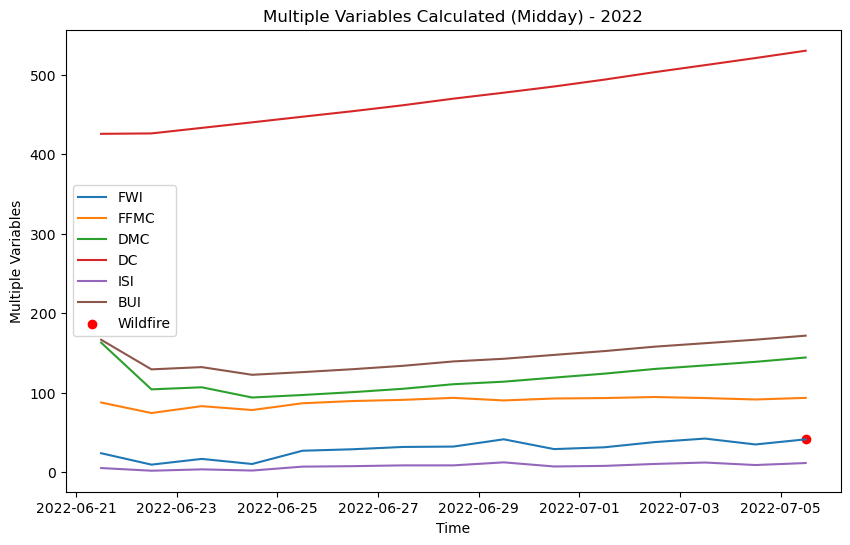

In [12]:
ofmd = pd.read_csv('Samples/2022/2022MidDayFWIX.csv')

ofmd['hourly.time'] = pd.to_datetime(ofmd['hourly.time'])

metvar = "Multiple Variables"
__year = 2022

plt.figure(figsize=(10,6))
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['fwix']), label=f'FWI')
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['ffmc']), label=f'FFMC')
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['dmc']), label=f'DMC')
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['dc']), label=f'DC')
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['isi']), label=f'ISI')
plt.plot(np.array(ofmd['hourly.time']), np.array(ofmd['bui']), label=f'BUI')

plt.scatter(np.array(ofmd['hourly.time'].iloc[-1]), np.array(ofmd['fwix'].iloc[-1]), color='red', label='Wildfire')
plt.xlabel('Time')
plt.ylabel(f'{metvar}')
plt.title(f'{metvar} Calculated (Midday) - {__year}')
plt.legend()
plt.savefig(f'{__year}Calc{metvar}12.png', dpi=300)
plt.show()